In [1]:
import ta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import mplfinance as mpf

In [2]:
datatrain = pd.read_csv("aapl_5m_train.csv")
dataval = pd.read_csv('aapl_5m_validation.csv')
datatrain.head()

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,1641220200,0,2022-01-03 14:30:00,177.830001,179.309997,177.710006,178.964996,4441780.0
1,1641220500,0,2022-01-03 14:35:00,178.970001,180.399993,178.919998,180.330001,2482136.0
2,1641220800,0,2022-01-03 14:40:00,180.330001,180.839996,180.210006,180.595001,2219825.0
3,1641221100,0,2022-01-03 14:45:00,180.600006,180.750000,179.470001,179.940002,2018163.0
4,1641221400,0,2022-01-03 14:50:00,179.929992,180.229904,179.399993,180.210006,1944837.0


In [3]:
#Choosing indicators
short_sma= ta.trend.SMAIndicator(datatrain.Close, window=5)
long_sma= ta.trend.SMAIndicator(datatrain.Close, window=15)
macd = ta.trend.MACD(datatrain.Close, window_slow = 26,
    window_fast = 12,
    window_sign = 9,
    fillna = False)
rsi = ta.momentum.RSIIndicator(datatrain.Close, window = 14,
    fillna = False,)



short_ema = ta.trend.EMAIndicator(datatrain.Close, window=10)
long_ema = ta.trend.EMAIndicator(datatrain.Close, window=30)

bollinger_bands = ta.volatility.BollingerBands(datatrain.Close, window=20, window_dev=2)


In [4]:
#Create columns with indicators
datatrain["short_sma"] = short_sma.sma_indicator()
datatrain["long_sma"] = long_sma.sma_indicator()
datatrain['MACD'] = macd.macd()
datatrain['MACDS'] = macd.macd_signal()
datatrain["RSI"] = rsi.rsi()
datatrain["long_ema"] = long_ema.ema_indicator()
datatrain["short_ema"] = short_ema.ema_indicator()
datatrain["bollinger"] = bollinger_bands.bollinger_mavg()

In [5]:
datatrain.head()

,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,short_sma,long_sma,MACD,MACDS,RSI,long_ema,short_ema,bollinger
0,1641220200,0,2022-01-03 14:30:00,177.830001,179.309997,177.710006,178.964996,4441780.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1641220500,0,2022-01-03 14:35:00,178.970001,180.399993,178.919998,180.330001,2482136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1641220800,0,2022-01-03 14:40:00,180.330001,180.839996,180.210006,180.595001,2219825.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1641221100,0,2022-01-03 14:45:00,180.600006,180.750000,179.470001,179.940002,2018163.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1641221400,0,2022-01-03 14:50:00,179.929992,180.229904,179.399993,180.210006,1944837.0,180.008001,NaN,NaN,NaN,NaN,NaN,NaN,NaN


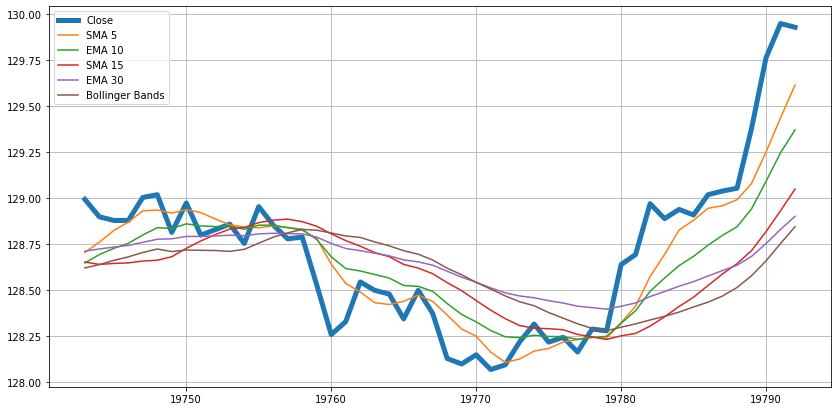

In [6]:
plt.figure(figsize=(14, 7))
plt.grid(True)
plt.plot(datatrain.Close[-50:], label = 'Close', linewidth = 5)
plt.plot(datatrain.short_sma[-50:], label = 'SMA 5')
plt.plot(datatrain.short_ema[-50:], label = 'EMA 10')
plt.plot(datatrain.long_sma[-50:], label = 'SMA 15')
plt.plot(datatrain.long_ema[-50:], label = 'EMA 30')
plt.plot(datatrain.bollinger[-50:], label = 'Bollinger Bands')
plt.legend();
plt.show()

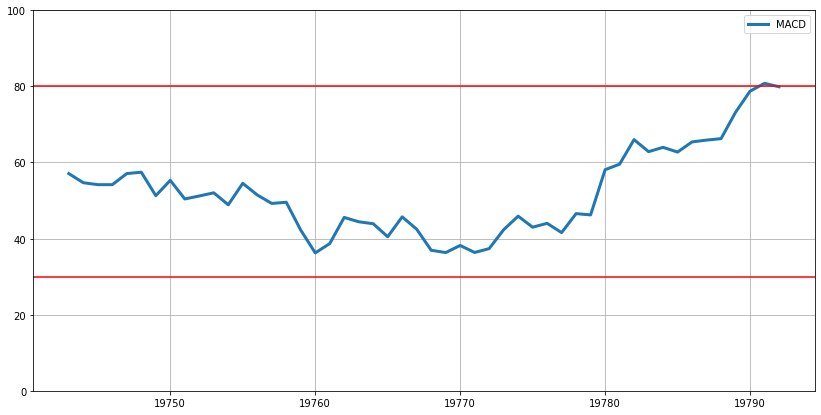

In [7]:
plt.figure(figsize=(14, 7))
plt.grid(True)
plt.plot(datatrain.RSI[-50:], label = 'MACD', linewidth = 3)
plt.axhline(y=30, color = 'r', linestyle = '-')
plt.axhline(y=80, color = 'r', linestyle = '-')
plt.legend()
plt.ylim(0,100)
plt.show()

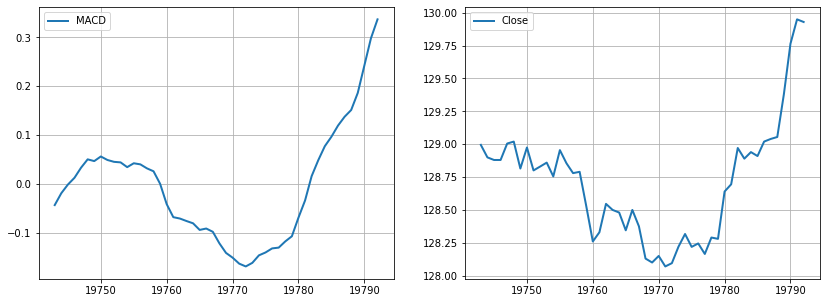

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: MACD
axs[0].grid(True)
axs[0].plot(datatrain.MACD[-50:], label='MACD', linewidth=2)
axs[0].legend()

# Second subplot: Close
axs[1].grid(True)
axs[1].plot(datatrain.Close[-50:], label='Close', linewidth=2)
axs[1].legend()

plt.show()

## Define buy/sell signals for each indicator.

In [9]:
#Set the Buy and Sell signals
datatrain['buy_signal_sma'] = datatrain.short_sma < datatrain.long_sma
datatrain['sell_signal_sma'] = datatrain.short_sma > datatrain.long_sma

datatrain['buy_signal_ema'] = datatrain.short_ema < datatrain.long_ema
datatrain['sell_signal_ema'] = datatrain.short_ema > datatrain.long_ema

datatrain['buy_signal_rsi'] = datatrain.RSI == 30
datatrain['sell_signal_rsi'] = datatrain.RSI == 80

datatrain['buy_signal_bollinger'] = datatrain.bollinger < datatrain.Close
datatrain['sell_signal_bollinger'] = datatrain.bollinger > datatrain.Close

datatrain['buy_signal_MACD'] = datatrain.MACD > 0
datatrain['sell_signal_MACD'] = datatrain.MACD < 0

## Create all possible combinations of all technical indicators: 2^n - 1

In [10]:
# List of indicator column names
indicator_columns = [
    "short_sma",
    "long_sma",
    "MACD",
    "MACDS",
    "RSI",
    "long_ema",
    "short_ema",
    "bollinger",
]

# Generate all possible combinations of indicator columns (2^n - 1 combinations)
all_indicator_combinations = set()

# Loop through different numbers of indicators (from 1 to the total number of indicators)
for num_indicators in range(1, len(indicator_columns) + 1):
    # Generate all combinations of indicator columns for the current number of indicators
    combinations = itertools.combinations(indicator_columns, num_indicators)
    
    # Add the combinations to the set (duplicates will be automatically removed)
    all_indicator_combinations.update(combinations)

# Convert the set of combinations to a list of lists for easier access
all_indicator_combinations = [list(combination) for combination in all_indicator_combinations]

# Print all unique indicator combinations
for combination in all_indicator_combinations:
    print(combination)


['short_sma', 'long_sma', 'MACDS', 'RSI', 'long_ema', 'bollinger']
['RSI', 'bollinger']
['short_sma', 'long_sma', 'short_ema', 'bollinger']
['short_sma', 'MACD', 'MACDS', 'RSI', 'long_ema']
['short_sma', 'long_sma', 'MACDS', 'bollinger']
['long_sma', 'MACDS', 'bollinger']
['short_sma', 'long_sma', 'MACD']
['long_sma', 'MACD', 'long_ema', 'short_ema', 'bollinger']
['short_sma', 'RSI', 'bollinger']
['MACD', 'long_ema']
['short_sma', 'long_sma', 'MACD', 'RSI', 'long_ema', 'bollinger']
['short_sma', 'long_sma', 'MACDS', 'long_ema', 'short_ema', 'bollinger']
['short_sma', 'MACD']
['short_sma', 'long_sma', 'MACDS', 'long_ema']
['short_sma', 'MACD', 'MACDS', 'short_ema', 'bollinger']
['short_sma', 'MACDS', 'bollinger']
['MACDS', 'RSI', 'bollinger']
['short_sma', 'long_sma', 'long_ema', 'bollinger']
['short_sma', 'RSI', 'long_ema', 'short_ema', 'bollinger']
['short_sma', 'MACD', 'long_ema', 'short_ema']
['short_sma', 'long_sma', 'MACD', 'MACDS', 'RSI', 'bollinger']
['short_sma', 'long_sma', 'M

## Backtest the strategies while keeping track of the operations and cash/portfolio value time series.

In [11]:
class Order:
    def __init__(self, timestamp, bought_at, stop_loss, take_profit, order_type, sold_at = None, 
                 is_active: bool = True):
        self.timestmap = timestamp
        self.bought_at = bought_at
        self.sold_at = sold_at
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.order_type = order_type
        self.is_active = is_active

    def __repr__(self) -> str:
        return f"{self.order_type} Position - id {self.timestamp}"
    
    def __str__(self) -> str:
        return f"{self.order_type} {self.is_active} Position @ {self.bought_at}"

## Optimize all technical indicator's parameters, stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!

In [12]:
COMISSION = 0 #for this case
STOP_LOSS = 0.03
TAKE_PROFIT = 0.03
cash = 1_000_000
positions = []
operations = []

long_operations = []
short_operations = []

for i, row in datatrain.iterrows():       
    
    if cash < 0:
        print("AAAAAAAA")
        break
    
    #Close positions
    price = row.Close
    for position in positions:
        j = positions.index(position)
        if position.is_active:
            if position.order_type == "LONG":
                if price <= position.stop_loss:
                    print("CLOSED LONG")
                    cash += price * (1-COMMISSION)
                    position.is_active = False 
                    position.sold_at = price
                    # print(f"Closing active position - Bought at {position.bought_at}"+
                    #      f"- Sold at {position.sold_at}")


                elif price >= position.take_profit:
                    print("CLOSED LONG")
                    cash += price * (1-COMMISSION)
                    position.is_active = False 
                    position.sold_at = price
                    # print(f"Closing active position - Bought at {position.bought_at}"+
                    #          f"- Sold at {position.sold_at}")
            else:
                if price >= position.stop_loss:
                    cash -= price * (1-COMMISSION)
                    position.is_active = False 
                    position.sold_at = price
                    print(f"(LOSS) - Closing short position - Bought at {position.bought_at}"+
                          f"- Sold at {position.sold_at}")


                elif price <= position.take_profit:
                    cash -= price * (1-COMMISSION)
                    position.is_active = False 
                    position.sold_at = price
                    print(f"(PROFIT) - Closing short position - Bought at {position.bought_at}"+
                          f"- Sold at {position.sold_at}")

                if (price + 2 * (position.bought_at - price)) > cash:
                    cash -= price * (1-COMMISSION)
                    position.is_active = False 
                    position.sold_at = price
                    # Close position
                    print(f"(MARGIN CALL) - Closing short position - Bought at {position.bought_at}"+
                          f"- Sold at {position.sold_at}")

#Signals
# buy_signal_sma, buy_signal_ema, buy_signal_rsi, buy_signal_bollinger, buy_signal_MACD
# sell_signal_sma, sell_signal_ema, sell_signal_rsi, sell_signal_bollinger, sell_signal_MACD

    #Buy
    if row.buy_signal_sma and row.buy_signal_ema and row.buy_signal_rsi and row.buy_signal_bollinger and row.buy_signal_MACD:
        if cash < row.Close*(1+COMMISSION):
            continue
        cash -= row.Close*(1+COMMISSION)
        order = Order(
            timestamp = row.Timestamp,
            bought_at = row.Close,
            stop_loss = row.Close*(1-STOP_LOSS),
            take_profit = row.Close*(1+TAKE_PROFIT),
            order_type = "LONG"
        )
        positions.append(order)
        long_operations.append(1)



   #Sell     
    if row.sell_signal_sma and row.sell_signal_ema and row.sell_signal_rsi and row.sell_signal_bollinger and row.sell_signal_MACD:
        if cash < row.Close * (1+COMMISSION):
            continue
        cash += row.Close*(1-COMMISSION)
        order = Order(
            timestamp = row.Timestamp,
            bought_at = row.Close,
            stop_loss = row.Close*(1+STOP_LOSS),
            take_profit = row.Close*(1-TAKE_PROFIT),
            order_type = "SHORT"
        )
        positions.append(order)
        short_operations.append(1)


In [13]:
cash

1000000

C:\ANACONDA3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


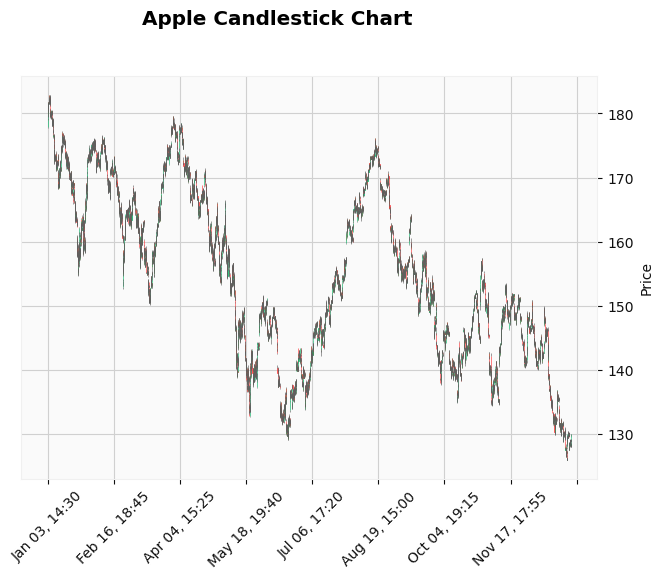

In [14]:
# Convert the 'Date' column to a datetime format if it's not already
datatrain['Datetime'] = pd.to_datetime(datatrain['Datetime'])

# Set the 'Date' column as the index
datatrain.set_index('Datetime', inplace=True)

# Create a candlestick chart
mpf.plot(datatrain, type='candle', style='yahoo', title="Apple Candlestick Chart", ylabel="Price")

## Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).

## Now, use the optimal strategy with the validation dataset and compare it to a passive strategy.

## Present the results & conclusions in a Jupyter notebook (without unnecessary code, only plot-related things), include the list of the operations, candlestick charts, indicators, trading signals, cash through time, portfolio value through time, and any other chart that you consider important.